# Q1. (20%) Build a single Pipeline that conducts not just data engineering and preprocessing as in the lecture, but also machine learning (including hyper-parameter tuning) using the logistic regression model.


In [32]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop = columns_to_drop
        
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        
        return output_df

def get_machine_learning_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x + "_index" for x in nominal_cols]
    nominal_onehot_cols = [x + "_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols + binary_cols + nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    
    # Using the logistic regression model
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
    lr_paramGrid = (ParamGridBuilder()
                     .addGrid(lr.regParam, [0.01, 0.5, 2.0])
                     .addGrid(lr.maxIter, [1, 5, 10])
                     .build())
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
                                                labelCol='outcome', metricName='areaUnderROC')
    lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, stage_nominal_onehot_encoder,
        stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper, lr_cv])
    
    return pipeline 

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('./NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

machine_learning_pipeline = get_machine_learning_pipeline()
machine_learning_model = machine_learning_pipeline.fit(nslkdd_raw)

nslkdd_df = machine_learning_model.transform(nslkdd_raw)
nslkdd_df_test = machine_learning_model.transform(nslkdd_test_raw)

In [33]:
nslkdd_df.printSchema()
nslkdd_df.show(1)

nslkdd_df_test.printSchema()
nslkdd_df_test.show(1)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------------------+-------+--------------------+--------------------+----------+
|            features|outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(113,[1,13,14,17,...|    0.0|[2.07747078029120...|[0.88869409656158...|       0.0|
+--------------------+-------+--------------------+--------------------+----------+
only showing top 1 row

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------------------+-------+--------------------+--------------------+----------+
|            features|outcome|       raw

# Q2. (80%) Use sparkML to predict not just whether there is an attack, but also the type of the attack. In other words, this is a multi-class classification problem with 5 possible categories (normal, DOS, R2L, U2R, probing)

##  Q2-1 (20%) Create a preprocess pipeline that conducts the usual data engineering steps (as in the lecture), and also create an outcome column that indicates which of the 5 categories the record belongs to.

In [44]:
class OutcomeCreater_multi(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()
        
    def _label_to_categories(self, name):   
        dos_attacks = ['apache2', 'back', 'land', 'neptune', 'mailbomb',
               'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
        
        probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
        
        u2r_attacks = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
        
        if name == 'normal':
            return 0.0
        elif name in dos_attacks:
            return 1.0
        elif name in probe_attacks:
            return 2.0
        elif name in u2r_attacks:
            return 3.0
        else: # R2L
            return 4.0
            
    def _transform(self, dataset):
        label_to_categories = udf(self._label_to_categories, DoubleType()) #convert to udf !!!
        output_df = dataset.withColumn('outcome', label_to_categories(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df
    
def get_preprocess_multi_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater_multi()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 


preprocess_multi_pipeline = get_preprocess_multi_pipeline()
get_preprocess_multi_model = preprocess_multi_pipeline.fit(nslkdd_raw)

nslkdd_m_df = get_preprocess_multi_model.transform(nslkdd_raw)
nslkdd_m_df_test = get_preprocess_multi_model.transform(nslkdd_test_raw)


In [51]:
nslkdd_m_df.printSchema()
nslkdd_m_df.show(15)

nslkdd_m_df_test.printSchema()
nslkdd_m_df_test.show(15)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|    0.0|
|(113,[1,13,14,17,...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    4.0|
|(113,[13,14,15,18...|    1.0|
+--------------------+-------+
only showing top 15 rows

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[0,1,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    2.0|
|(113,[0,2,13,14,1...|    2.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...

## Q2-2 (25%) Select 2 machine learning models. For each of the machine learning models, train it on the training dataset. Calculate the train and test accuracy, and plot the confusion matrix (for the predictions on the test dataset).

### 1. Logistic Regression

In [80]:
lr_m = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
lr_m_model = lr_m.fit(nslkdd_m_df) # fit the logistic regression model to the training dataset
predictions = lr_m_model.transform(nslkdd_m_df_test)

predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [82]:
predictions_train = lr_m_model.transform(nslkdd_m_df)# predictions using the training dataset
accuracy_train = (predictions_train.filter(predictions_train.outcome == predictions_train.prediction)
    .count() / float(predictions_train.count()))

accuracy_test = (predictions.filter(predictions.outcome == predictions.prediction)
    .count() / float(predictions.count()))
print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")



Train Accuracy : 98.76%
Test Accuracy : 75.92%


In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9037  422  248    4    0]
 [1210 6238   11    0    1]
 [ 492  125 1695    1  108]
 [  44    2    0   17    4]
 [2747    3    3    3  129]]


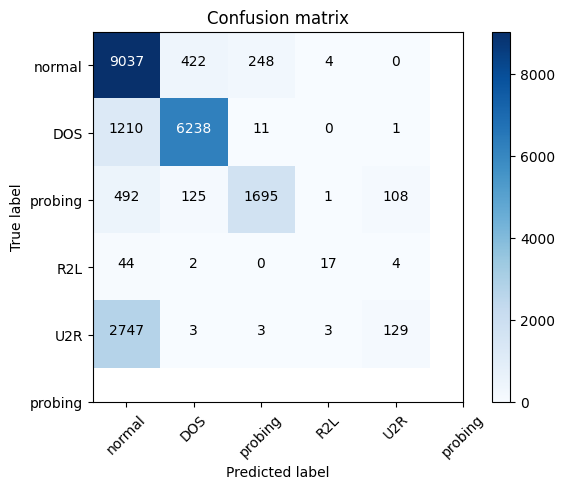

In [84]:
class_names=[0.0,1.0,2.0,3.0,4.0]
class_names_str=["normal", "DOS", "probing", "R2L", "U2R", "probing"]

outcome_true = predictions.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)

#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

### 2. Random Forest

In [85]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rf.fit(nslkdd_m_df)

rf_prediction_train = rf_model.transform(nslkdd_m_df)
rf_prediction_test = rf_model.transform(nslkdd_m_df_test)

rf_accuracy_train = (rf_prediction_train.filter(rf_prediction_train.outcome == rf_prediction_train.prediction)
    .count()/ float(rf_prediction_train.count()))
rf_accuracy_test = (rf_prediction_test.filter(rf_prediction_test.outcome == rf_prediction_test.prediction)
    .count() / float(rf_prediction_test.count()))


print(f"Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}")


Train accuracy = 97.52%, test accuracy = 71.93


Confusion matrix, without normalization
[[9492   43  176    0    0]
 [2136 5320    4    0    0]
 [ 719  298 1404    0    0]
 [  67    0    0    0    0]
 [2868    2   15    0    0]]


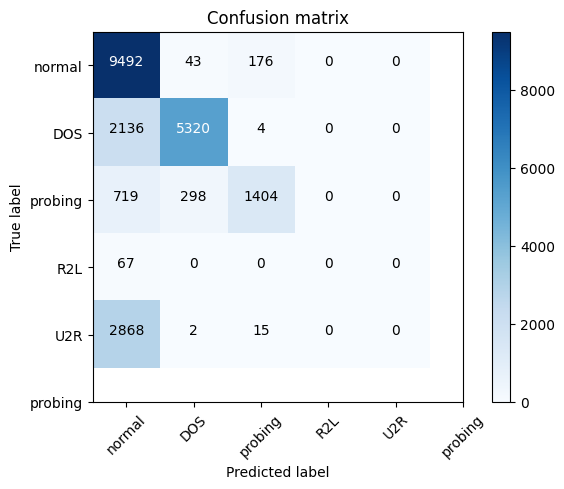

In [86]:
outcome_true = rf_prediction_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = rf_prediction_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)

#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

## Q2-3 (25%) For each of the 2 machine learning models, identify 2 hyper parameters, build a parameter grid and conduct hyper-parameter tuning using cross-validation, with accuracy as the metric. Calculate the test accuracy after tuning. 

### 1. Logistic Regression

In [91]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
lr_paramGrid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.0, 0.01, 0.02])
                 .addGrid(lr.maxIter, [50, 100, 150])
                 .build())

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", 
                                            labelCol='outcome', metricName='accuracy')
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                evaluator=evaluator, numFolds=5)

lr_cv_model = lr_cv.fit(nslkdd_m_df) # fit the logistic regression model to the training dataset
predictions = lr_cv_model.transform(nslkdd_m_df_test)


accuracy_test = (predictions.filter(predictions.outcome == predictions.prediction)
    .count() / float(predictions.count()))

print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")

Test Accuracy : 75.76%


In [101]:
lr_cv_model.bestModel

LogisticRegressionModel: uid=LogisticRegression_d2925c1a319f, numClasses=5, numFeatures=113

### 2. Random Forest

In [92]:
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])# maximum depth for each tree
             .addGrid(rf.numTrees,[10, 20, 40])# number of trues
             .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, 
                    evaluator=evaluator, numFolds=5)

rf_cv_model = rf_cv.fit(nslkdd_m_df)

rf_cv_prediction_test = rf_cv_model.transform(nslkdd_m_df_test)


accuracy_test = (rf_cv_prediction_test.filter(rf_cv_prediction_test.outcome == rf_cv_prediction_test.prediction)
    .count() / float(rf_cv_prediction_test.count()))

print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")

22/10/30 05:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB


22/10/30 05:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1061.0 KiB


22/10/30 05:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1413.6 KiB


22/10/30 05:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1813.5 KiB


22/10/30 05:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1244.2 KiB
22/10/30 05:22:24 WARN DAGScheduler: Broadcasting large task binary with size 1017.8 KiB
22/10/30 05:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
22/10/30 05:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1222.0 KiB
22/10/30 05:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1445.1 KiB
22/10/30 05:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1654.7 KiB
22/10/30 05:22:29 WARN DAGScheduler: Broadcasting large task binary with size 1842.5 KiB
22/10/30 05:22:29 WARN DAGScheduler: Broadcasting large task binary with size 2000.0 KiB
22/10/30 05:22:30 WARN DAGScheduler: Broadcasting large task binary with size 1218.5 KiB


22/10/30 05:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1061.0 KiB


22/10/30 05:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1413.6 KiB


22/10/30 05:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1813.5 KiB


22/10/30 05:22:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/30 05:22:38 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/30 05:22:40 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/10/30 05:22:41 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/10/30 05:22:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/30 05:22:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/30 05:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1073.3 KiB


22/10/30 05:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1428.5 KiB


22/10/30 05:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1817.8 KiB


22/10/30 05:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1232.9 KiB
22/10/30 05:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
22/10/30 05:23:10 WARN DAGScheduler: Broadcasting large task binary with size 1138.1 KiB
22/10/30 05:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/30 05:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1512.1 KiB
22/10/30 05:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1679.8 KiB
22/10/30 05:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1824.6 KiB
22/10/30 05:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.8 KiB


22/10/30 05:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1073.3 KiB


22/10/30 05:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1428.5 KiB


22/10/30 05:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1817.8 KiB


22/10/30 05:23:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/30 05:23:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/30 05:23:23 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/30 05:23:25 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/30 05:23:27 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/30 05:23:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/30 05:23:40 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB


22/10/30 05:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1074.4 KiB


22/10/30 05:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB


22/10/30 05:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1872.9 KiB


22/10/30 05:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1267.5 KiB
22/10/30 05:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1044.8 KiB
22/10/30 05:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
22/10/30 05:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1226.7 KiB
22/10/30 05:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1425.5 KiB
22/10/30 05:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1602.3 KiB
22/10/30 05:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1751.2 KiB
22/10/30 05:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1870.0 KiB
22/10/30 05:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1128.7 KiB


22/10/30 05:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.4 KiB


22/10/30 05:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB


22/10/30 05:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1872.9 KiB


22/10/30 05:24:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/30 05:24:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/10/30 05:24:08 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/10/30 05:24:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/10/30 05:24:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/10/30 05:24:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/30 05:24:25 WARN DAGScheduler: Broadcasting large task binary with size 1020.9 KiB


22/10/30 05:24:30 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB


22/10/30 05:24:31 WARN DAGScheduler: Broadcasting large task binary with size 1395.4 KiB


22/10/30 05:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1795.8 KiB


22/10/30 05:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1219.3 KiB
22/10/30 05:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1029.3 KiB
22/10/30 05:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1020.9 KiB
22/10/30 05:24:41 WARN DAGScheduler: Broadcasting large task binary with size 1229.8 KiB
22/10/30 05:24:41 WARN DAGScheduler: Broadcasting large task binary with size 1418.9 KiB
22/10/30 05:24:42 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB
22/10/30 05:24:42 WARN DAGScheduler: Broadcasting large task binary with size 1743.6 KiB
22/10/30 05:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1871.1 KiB
22/10/30 05:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1137.0 KiB


22/10/30 05:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB


22/10/30 05:24:48 WARN DAGScheduler: Broadcasting large task binary with size 1395.4 KiB


22/10/30 05:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1795.8 KiB


22/10/30 05:24:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/30 05:24:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/30 05:24:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/30 05:24:55 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/10/30 05:24:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/30 05:24:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/30 05:25:13 WARN DAGScheduler: Broadcasting large task binary with size 1026.6 KiB


22/10/30 05:25:14 WARN DAGScheduler: Broadcasting large task binary with size 1387.3 KiB


22/10/30 05:25:16 WARN DAGScheduler: Broadcasting large task binary with size 1796.0 KiB


22/10/30 05:25:17 WARN DAGScheduler: Broadcasting large task binary with size 1219.1 KiB
22/10/30 05:25:23 WARN DAGScheduler: Broadcasting large task binary with size 1192.3 KiB
22/10/30 05:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1389.6 KiB
22/10/30 05:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1578.4 KiB
22/10/30 05:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1746.9 KiB


22/10/30 05:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1881.3 KiB
22/10/30 05:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1151.1 KiB


22/10/30 05:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1026.6 KiB


22/10/30 05:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1387.3 KiB


22/10/30 05:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1796.0 KiB


22/10/30 05:25:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/30 05:25:35 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/30 05:25:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/10/30 05:25:38 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/10/30 05:25:41 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/30 05:25:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/30 05:25:54 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB


22/10/30 05:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1409.7 KiB


22/10/30 05:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1825.7 KiB


22/10/30 05:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/30 05:26:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/10/30 05:26:05 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/10/30 05:26:08 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/30 05:26:11 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/10/30 05:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Test Accuracy : 77.06%


In [102]:
rf_cv_model.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_e78c217d8799, numTrees=40, numClasses=5, numFeatures=113

## Q2-4 (10%) In your own words, explain why you chose the two machine learning models, and for each of the two models, why you chose the 2 hyper-parameters to tune, and how you designed the parameter grid. Also, please include a discussion on the comparison of the two models.

I chose logistic regression and random forest because they are the most common classification models and both are suitable for multiclass classification.

[Logistic Regression]
I chose to fine-tune the two most important hyperparameters for logistic regression: maxIter and regParam. maxIter represents the number of training sessions. If it is too large, it may cause over-fitting, but if it is too small, it may cause under-fitting. Therefore, I design the parameter grid based on the preset 100, and increase or decrease it by 50 at the top and bottom. regParam represents Regularization in the formula of logistic regression, the purpose is to prevent overfitting by penalizing. I started from the preset 0.0 (i.e. no penalty) and increased upwards by 0.01 (because the minimum is zero) to avoid the penalty being too large and the model being too constrained and underfitting.

[Random Forest] I chose to fine-tune the two most important hyperparameters of random forests: maxDepth and numTrees. maxDepth represents the depth of the generated decision tree. If it is too large, it may cause overfitting, but if it is too small, it may underfit. Therefore, I design the parameter grid based on the preset 5, and increase it by 5 in turn (because 5 is already small ). Random forest is an ensemble model, so numTrees, which represents the number of decision trees, is particularly important, and the impact is like maxIter of logistic regression. When designing the parameter grid, the preset 20 is used as the benchmark, and it is increased or decreased to both sides.

[comparison] In terms of accuracy on the test set, the random forest model fine-tuned with hyperparameters has the best performance among the four models, although logistic regression performs better than random forest before fine-tuning. I guess this means that the random forest model has more growth potential than logistic regression and can be improved a lot by tuning the hyperparameters. In contrast, the performance difference before and after the logistic regression fine-tuning is not significant, and the preset parameter values may reach the limit of the model. Besides, logistic regression requires 100 repetitions of training to achieve the best results while random forest only needs 40 trees, but logistic regression is faster than random forest. Therefore, if the pursuit of efficiency, logistic regression can quickly provide results with a certain accuracy, on the contrary, if the pursuit of accuracy, you need to spend time fine-tuning and training random forests to achieve better performance.